## Introducción

El objetivo de esta tarea es evaluar su capacidad para aplicar modelos de redes neuronales recurrentes (RNN) en un problema de clasificación de señales. En particular, vamos a evaluar la performance de sus modelos en la clasificación de ritmos cardíacos usando datos del electrocardiograma (ECG).

**Dataset**

El dataset a ser utilizado es el [MIT-BIH Arrhythmia Database](https://physionet.org/content/mitdb/1.0.0). Este dataset contiene registros de ECG que permiten estudiar la actividad eléctrica del corazón y está diseñado para facilitar la clasificación de diferentes tipos de arritmias. Pueden encontrar más información y descargar el dataset en el link proporcionado.

In [ ]:
!pip install torchinfo

In [ ]:
!unzip /content/archive-mit.zip

Archive:  /content/archive-mit.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


In [ ]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 11.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np
from collections import Counter
import os
import matplotlib.pyplot as plt
from sklearn.utils import resample

from torchinfo import summary

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
)

import wfdb

from IPython.display import Image, display

from sklearn.model_selection import train_test_split

from utils import train, evaluate, plot_taining

In [ ]:
DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"

print(f"Usando {DEVICE}")

NUM_WORKERS = 1

Usando cuda


# **PREPROCESAMIENTO DE DATOS**

In [ ]:
TRAIN_DATA_PATH = "/content/mitbih_train.csv"
TEST_DATA_PATH = "/content/mitbih_test.csv"

In [ ]:
df_train = pd.read_csv(TRAIN_DATA_PATH, header=None)
df_test = pd.read_csv(TEST_DATA_PATH, header=None)

# Concatenamos los datos de entrenamiento y test
df = pd.concat([df_train, df_test], axis=0)

In [ ]:
ninputs = df.shape[1] - 1
nclasses = df.iloc[:, -1].nunique()
print(f"Existen {nclasses} clases y {ninputs} características")

Existen 5 clases y 187 características


In [ ]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train = df_train.iloc[:, :-1]  # Extraemos las características
y_train = df_train.iloc[:, -1]  # Extraemos las etiquetas

X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

187
0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: count, dtype: int64


<Axes: xlabel='187'>

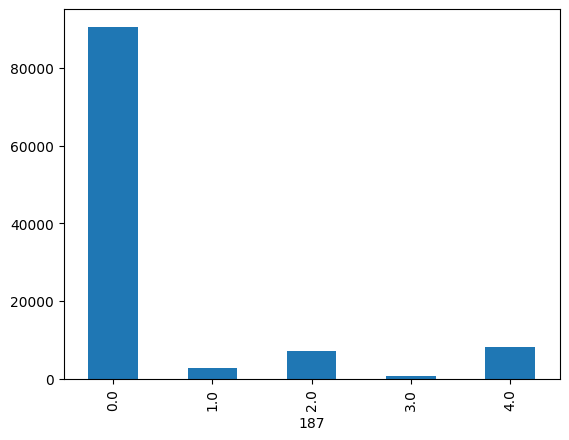

In [ ]:
class_count = df.iloc[:, -1].value_counts()
print(class_count)

class_count.sort_index().plot(kind="bar")

In [ ]:
class MITBIHDataSet(Dataset):
    def __init__(self, df_features, df_target, num_classes):
        # Convertir explícitamente a numpy arrays
        self.x_df = df_features.to_numpy() if hasattr(df_features, 'to_numpy') else df_features
        self.y_df = df_target.to_numpy() if hasattr(df_target, 'to_numpy') else df_target
        self.num_classes = num_classes

    def __len__(self):
        return len(self.x_df)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_df[idx], dtype=torch.float32)
        y = torch.tensor(self.y_df[idx], dtype=torch.long)
        return x, y

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

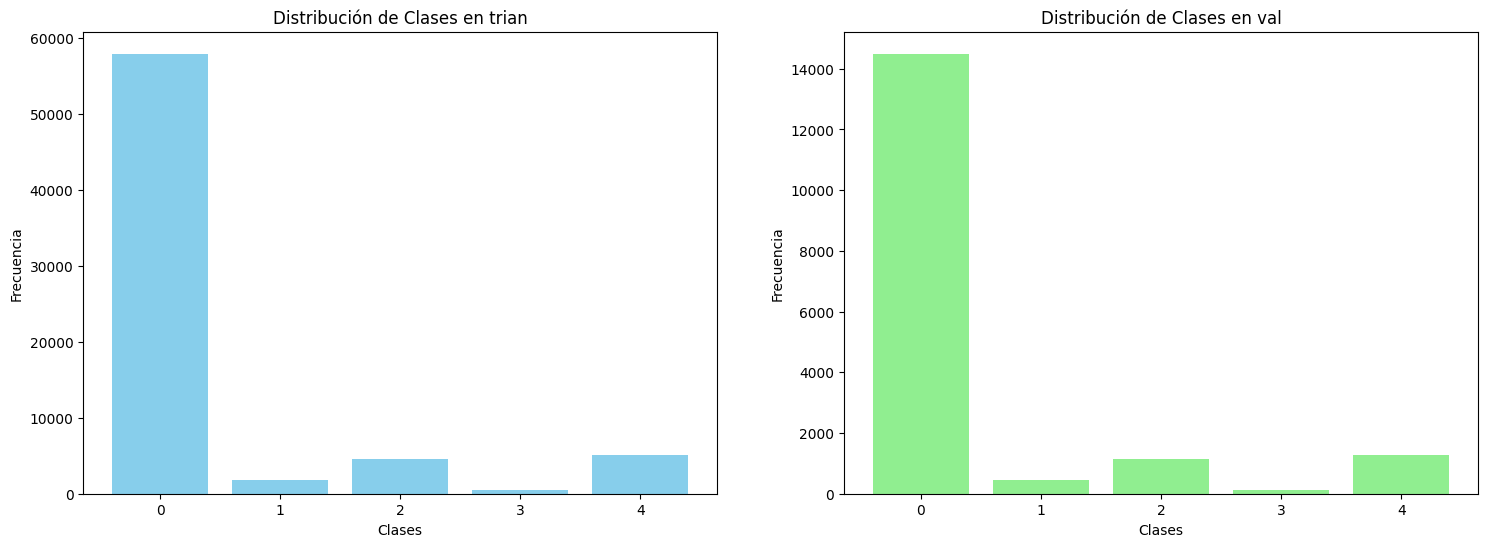

In [ ]:
# Contar la frecuencia de cada clase en cada conjunto
class_counts_train = y_train.value_counts()
class_counts_val = y_val.value_counts()

# Crear subplots para los histogramas
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histograma para train
axes[0].bar(class_counts_train.index, class_counts_train.values, color="skyblue")
axes[0].set_title("Distribución de Clases en trian")
axes[0].set_xlabel("Clases")
axes[0].set_ylabel("Frecuencia")

# Histograma para val
axes[1].bar(class_counts_val.index, class_counts_val.values, color="lightgreen")
axes[1].set_title("Distribución de Clases en val")
axes[1].set_xlabel("Clases")
axes[1].set_ylabel("Frecuencia")

plt.show()

In [ ]:
train_dataset = MITBIHDataSet(X_train, y_train, nclasses)
val_dataset = MITBIHDataSet(X_val, y_val, nclasses)
test_dataset = MITBIHDataSet(X_test, y_test, nclasses)

# **FUNCIONES AUXILIARES**

In [ ]:
def get_data_loaders(batch_size):

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    return train_loader, val_loader, test_loader

def model_classification_report(model, dataloader):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
      for x, y in dataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        output = model(x)
        preds = torch.argmax(output, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)

    print(f"Accuracy: {accuracy}")
    print(report)

def print_log(epoch, train_loss, val_loss):
    print(
        f"Epoch: {epoch + 1:03d}/{EPOCHS:03d} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}"
    )

# **DEFINICION DE MODELOS**

# **GRU**

In [ ]:
class RNN_GRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=4, num_layers=2, dropout=0.3):
        super(RNN_GRU, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=num_layers, dropout=dropout)
        self.batchNorm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch_size, seq_length, input_dim]
        x = x.unsqueeze(-1)
        out, _ = self.rnn(x)  # out: [batch_size, seq_length, hidden_size]
        out = self.batchNorm(out[:, -1, :])
        out = self.fc(out)    # [batch_size, output_size]
        #probas = torch.sigmoid(logits)
        return out

summary(RNN_GRU(input_size=1, hidden_size=128, output_size=4))

Layer (type:depth-idx)                   Param #
RNN_GRU                                  --
├─RNN: 1-1                               49,792
├─BatchNorm1d: 1-2                       256
├─Linear: 1-3                            516
Total params: 50,564
Trainable params: 50,564
Non-trainable params: 0

# **LSTM**

In [ ]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=4, num_layers=2, dropout=0.3):
        super(RNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)

        self.batchNorm = nn.BatchNorm1d(hidden_size)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(-1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.batchNorm(out[:, -1, :])

        out = self.fc(out)

        return out

summary(RNN_LSTM(input_size=1, hidden_size=128, output_size=4))

Layer (type:depth-idx)                   Param #
RNN_LSTM                                 --
├─LSTM: 1-1                              199,168
├─BatchNorm1d: 1-2                       256
├─Linear: 1-3                            516
Total params: 199,940
Trainable params: 199,940
Non-trainable params: 0

# **CRITERIO DE BALANCAMIENTO DE CLASES**

In [ ]:
class ClassBalancedLoss(nn.Module):
    def __init__(self, num_classes, beta=0.99):
        super(ClassBalancedLoss, self).__init__()
        self.num_classes = num_classes
        self.beta = beta

    def forward(self, logits, targets):
        # Calcular la frecuencia inversa de las clases
        target_freq = torch.bincount(targets, minlength=self.num_classes).float()
        target_freq = target_freq / target_freq.sum()
        weights = (1 - target_freq) ** self.beta
        weights = weights.to(logits.device)

        # Calcula la pérdida estándar de entropía cruzada
        loss_fn = nn.CrossEntropyLoss(weight=weights)
        return loss_fn(logits, targets)

# **ENTRENAMIENTO DE MODELOS**

In [ ]:
EPOCHS = 10
BATCH_SIZE = 64
LR = 0.001

In [ ]:
train_loader, val_loader, test_loader = get_data_loaders(
    BATCH_SIZE
)

In [ ]:
base_model = RNN_GRU(input_size=1, hidden_size=256, output_size=5, num_layers=2, dropout=0.3).to(DEVICE)
optimizer = optim.Adam(base_model.parameters(), lr=LR)

CRITERION = ClassBalancedLoss(num_classes=5, beta=0.99)

epoch_train_errors, epoch_val_errors = train(
    base_model,
    optimizer,
    CRITERION,
    train_loader,
    val_loader,
    DEVICE,
    epochs=EPOCHS,
    log_fn=print_log,
    patience=5
)

Epoch: 001/010 | Train Loss: 1.36122 | Val Loss: 1.30072
Epoch: 002/010 | Train Loss: 1.30214 | Val Loss: 1.30190
Epoch: 003/010 | Train Loss: 1.30210 | Val Loss: 1.30566
Epoch: 004/010 | Train Loss: 1.30007 | Val Loss: 1.33094
Epoch: 005/010 | Train Loss: 1.30201 | Val Loss: 1.30792
Epoch: 006/010 | Train Loss: 1.29986 | Val Loss: 1.29970
Epoch: 007/010 | Train Loss: 1.29905 | Val Loss: 1.29887
Epoch: 008/010 | Train Loss: 1.30050 | Val Loss: 1.29945
Epoch: 009/010 | Train Loss: 1.29871 | Val Loss: 1.30261
Epoch: 010/010 | Train Loss: 1.30081 | Val Loss: 1.29896


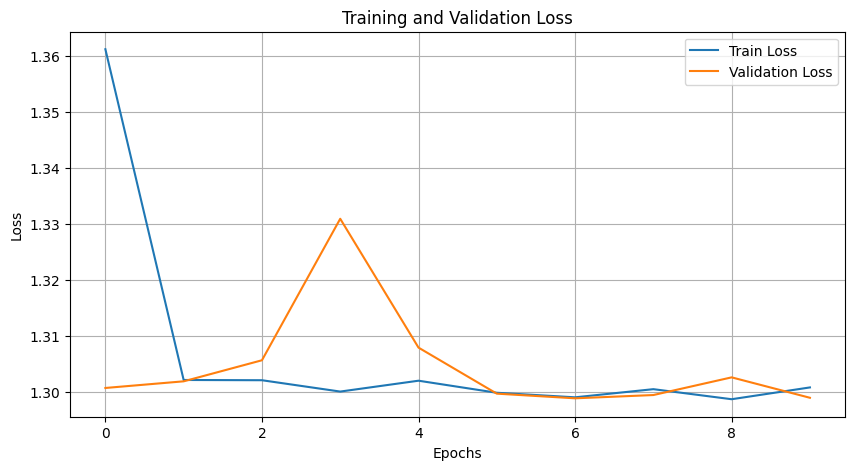

In [ ]:
plot_taining(epoch_train_errors, epoch_val_errors)

In [ ]:
model_classification_report(base_model, test_loader)

Accuracy: 0.8276082587246483
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     18118
           1       0.00      0.00      0.00       556
           2       0.00      0.00      0.00      1448
           3       0.00      0.00      0.00       162
           4       0.00      0.00      0.00      1608

    accuracy                           0.83     21892
   macro avg       0.17      0.20      0.18     21892
weighted avg       0.68      0.83      0.75     21892



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
base_model = RNN_LSTM(input_size=1, hidden_size=256, output_size=5, num_layers=2, dropout=0.3).to(DEVICE)
optimizer = optim.Adam(base_model.parameters(), lr=LR)
#CRITERION = nn.CrossEntropyLoss(weight=class_weights)
#CRITERION = FocalLoss(alpha=class_weights, gamma=2)
#CRITERION = focal_loss

CRITERION = ClassBalancedLoss(num_classes=5, beta=0.99)

epoch_train_errors, epoch_val_errors = train(
    base_model,
    optimizer,
    CRITERION,
    train_loader,
    val_loader,
    DEVICE,
    epochs=EPOCHS,
    log_fn=print_log,
    patience=5,

)

Epoch: 001/010 | Train Loss: 1.29786 | Val Loss: 1.44993
Epoch: 002/010 | Train Loss: 0.84232 | Val Loss: 0.95311
Epoch: 003/010 | Train Loss: 0.63842 | Val Loss: 1.27421
Epoch: 004/010 | Train Loss: 0.47157 | Val Loss: 0.40101
Epoch: 005/010 | Train Loss: 0.36376 | Val Loss: 0.31796
Epoch: 006/010 | Train Loss: 0.32148 | Val Loss: 0.31830
Epoch: 007/010 | Train Loss: 0.27108 | Val Loss: 0.27897
Epoch: 008/010 | Train Loss: 0.25577 | Val Loss: 0.26841
Epoch: 009/010 | Train Loss: 0.22923 | Val Loss: 0.21484
Epoch: 010/010 | Train Loss: 0.21808 | Val Loss: 0.21955


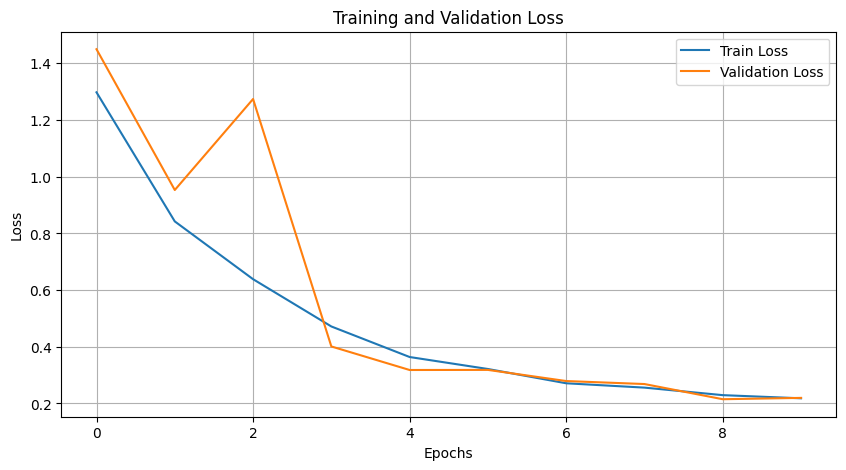

In [ ]:
plot_taining(epoch_train_errors, epoch_val_errors)

In [ ]:
model_classification_report(base_model, test_loader)

Accuracy: 0.9421249771606066
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     18118
           1       0.40      0.68      0.50       556
           2       0.81      0.95      0.87      1448
           3       0.80      0.61      0.69       162
           4       0.97      0.96      0.96      1608

    accuracy                           0.94     21892
   macro avg       0.79      0.83      0.80     21892
weighted avg       0.95      0.94      0.95     21892



# **Weights & Bias**

In [ ]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
WANDB_TEAM_NAME = "cardlean94-universidad-ort-uruguay"
WANDB_PROJECT = "Tarea2-lstm"

# La configuración del sweep: los parámetros que queremos optimizar
sweep_config = {
    "name": "sweep-lstm",
    "method": "bayes",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "learning_rate": {"distribution": "uniform", "min": 0.001, "max": 0.01},
        "dropout_rate": {"values": [0.2, 0.3, 0.4]},
        "optimizer": {"values": ["adam"]},
        "batch_size": {"values": [64, 128, 256]},
        "num_layers": {"values":[2, 4, 6]},
        "hidden_size": {"values": [64, 128, 256]},
        "beta": {"values": [0.99, 0.97]}
    },
    "early_terminate": {"type": "hyperband", "min_iter": 5},
}

# Crea un nuevo sweep (podríamos usar un sweep existente si ya lo hubiéramos creado)
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: ailo0phg
Sweep URL: https://wandb.ai/cardlean94-universidad-ort-uruguay/Tarea2-lstm/sweeps/ailo0phg


In [ ]:
EPOCHS = 30

def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()
    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_batch_size = config.batch_size
    hidden_size = config.hidden_size
    num_layers = config.num_layers
    dropout = config.dropout_rate
    beta = config.beta

    CRITERION = ClassBalancedLoss(num_classes=5, beta=beta)

    train_loader, val_loader, test_loader = get_data_loaders(
        BATCH_SIZE
    )

    model = RNN_LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, output_size=5, dropout=dropout).to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=run_learning_rate)

    train(
      model,
      optimizer,
      CRITERION,
      train_loader,
      val_loader,
      DEVICE,
      epochs=EPOCHS,
      log_fn=wand_log,
      patience=5,
    )

    # save model
    torch.save(model.state_dict(), "model.pth")
    wandb.save("model.pth")

    wandb.finish()

In [ ]:
wandb.agent(sweep_id, function=sweep_run, count=10)

wandb: Agent Starting Run: rrlghc6c with config:
wandb: 	batch_size: 128
wandb: 	beta: 0.99
wandb: 	dropout_rate: 0.3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0020716400530718044
wandb: 	num_layers: 4
wandb: 	optimizer: adam


Detener entrenamiento en la época 22, la mejor pérdida fue 0.21196


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
train_loss,███▇▅▄▄▃▃▃▃▂▂▂▁▁▁▁▁▂▂▃▂
val_loss,███▆▄▅▄▃▄▃▂▃▂▁▂▁▁▁▂▃▂▃▃
epoch,22
train_loss,0.46876
val_loss,0.49873


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m819jb1x with config:
wandb: 	batch_size: 128
wandb: 	beta: 0.99
wandb: 	dropout_rate: 0.4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001855731424758214
wandb: 	num_layers: 4
wandb: 	optimizer: adam


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█████▇▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█████▇▅▅▃▃▃▅▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁
epoch,29
train_loss,0.20423
val_loss,0.22186


wandb: Agent Starting Run: bf2l430y with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.99
wandb: 	dropout_rate: 0.2
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.002620567334936785
wandb: 	num_layers: 2
wandb: 	optimizer: adam


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch,29
train_loss,nan
val_loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9yi45eaq with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.99
wandb: 	dropout_rate: 0.2
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.005351955853277918
wandb: 	num_layers: 2
wandb: 	optimizer: adam


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
train_loss,0.21995
val_loss,0.22541


wandb: Agent Starting Run: sga5hmyw with config:
wandb: 	batch_size: 128
wandb: 	beta: 0.99
wandb: 	dropout_rate: 0.4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.006440461129696628
wandb: 	num_layers: 4
wandb: 	optimizer: adam


Detener entrenamiento en la época 9, la mejor pérdida fue 1.29848


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▁▂▁▁▁▁▁▁▁
val_loss,▃▂▁█▁▁▅▂▃▁
epoch,9
train_loss,1.30116
val_loss,1.29883


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9u1qznwh with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.97
wandb: 	dropout_rate: 0.3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.005858515667487984
wandb: 	num_layers: 2
wandb: 	optimizer: adam


Detener entrenamiento en la época 5, la mejor pérdida fue 1.25549


epoch,▁▂▄▅▇█
train_loss,▅▁████
val_loss,▁▇█▇█▇
epoch,5
train_loss,1.2921
val_loss,1.29027


wandb: Agent Starting Run: 4dhax0hn with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.99
wandb: 	dropout_rate: 0.4
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.002729559309838222
wandb: 	num_layers: 4
wandb: 	optimizer: adam


Detener entrenamiento en la época 16, la mejor pérdida fue 0.60931


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▇▇▆▅▄▃▃▃▂▂▂▂▁▁▄▆
val_loss,▅▅▅▄▃▂▂▂▁▁▁▁▁▂▂▇█
epoch,16
train_loss,1.06636
val_loss,1.61704


wandb: Agent Starting Run: t28ihi57 with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.97
wandb: 	dropout_rate: 0.4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.002901573803589691
wandb: 	num_layers: 6
wandb: 	optimizer: adam


Detener entrenamiento en la época 25, la mejor pérdida fue 1.14506


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▆▄▄▄▄▄▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_loss,█▄▅▅▅▅▄▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁
epoch,25
train_loss,1.16079
val_loss,1.15246


wandb: Agent Starting Run: epa0v1ac with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.99
wandb: 	dropout_rate: 0.4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001579502860235939
wandb: 	num_layers: 4
wandb: 	optimizer: adam


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▇▆▄▇▄▄▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅█▇▄▄▄▄▄▃▃▂▂▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
train_loss,0.13664
val_loss,0.12019


wandb: Agent Starting Run: 650qkdxn with config:
wandb: 	batch_size: 256
wandb: 	beta: 0.99
wandb: 	dropout_rate: 0.4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0023518238791227636
wandb: 	num_layers: 6
wandb: 	optimizer: adam


Detener entrenamiento en la época 15, la mejor pérdida fue 1.29841


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▅▅▁▃▂▂▁▂▁▇▃▃▁▃
epoch,15
train_loss,1.30025
val_loss,1.29947


In [ ]:
api = wandb.Api()

# nos traemos el sweep (objeto) para analizar los resultados
sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")

# obtenemos el mejor run
best_run = sweep.best_run()

# imprimimos el mejor run
print(f"Best run {best_run.name} with {best_run.summary['val_loss']}")

# descargamos el modelo del mejor run
best_run.file("model.pth").download(replace=True)

wandb: Sorting runs by +summary_metrics.val_loss


Best run effortless-sweep-15 with 0.12018725844643956


<_io.TextIOWrapper name='./model.pth' mode='r' encoding='UTF-8'>

# **RESULTADO DE TESTS**

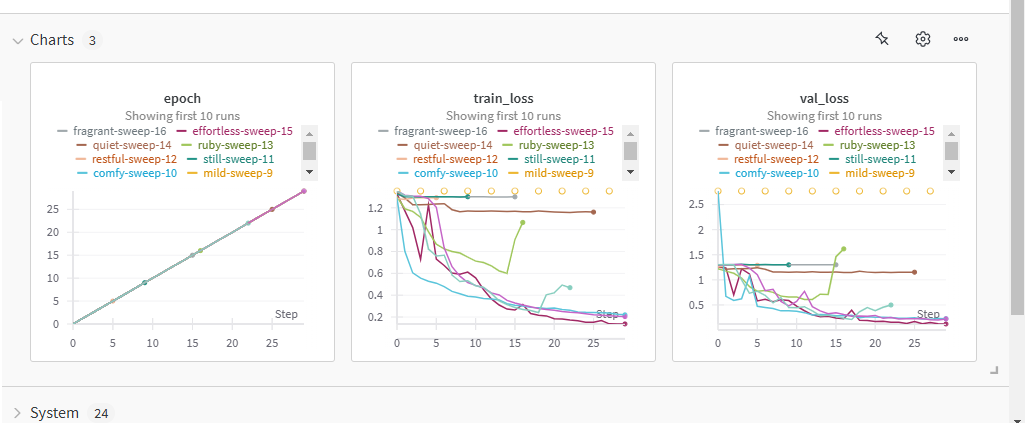

In [ ]:
display(Image(filename='/content/res1.png'))

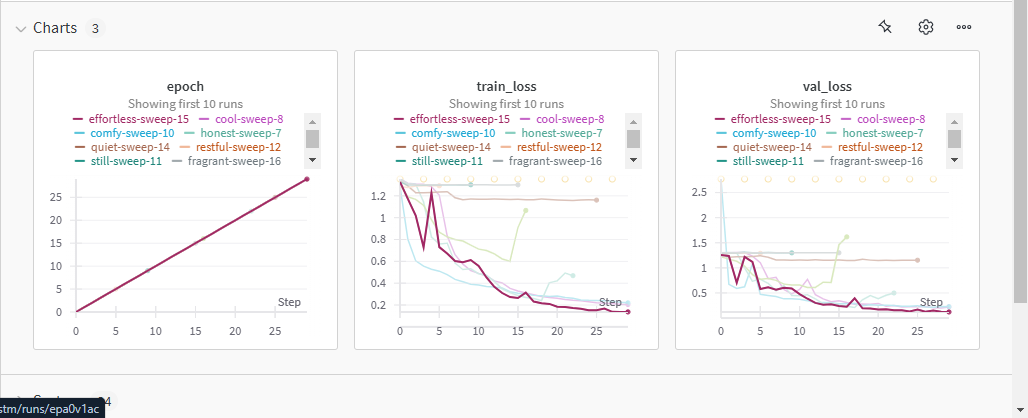

In [ ]:
display(Image(filename='/content/res2.png'))

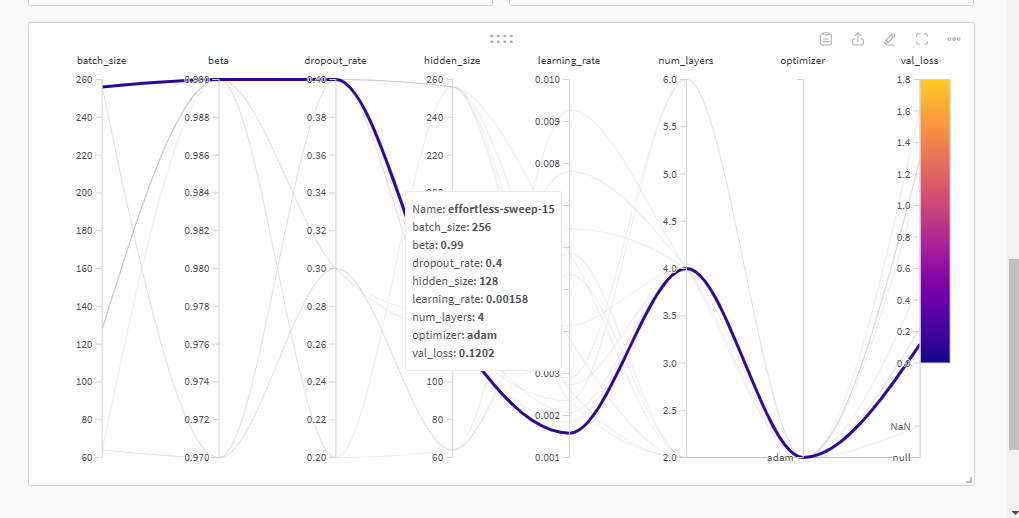

In [ ]:
display(Image(filename='/content/res3.png'))

# **MEJORES HIPERPARAMETROS EN MODELO**

In [ ]:
EPOCHS = 30  # Ajusta según sea necesario
BATCH_SIZE = 256
train_loader, val_loader, test_loader = get_data_loaders(
    BATCH_SIZE
)

In [ ]:
base_model = RNN_LSTM(input_size=1, hidden_size=128, output_size=5, num_layers=4, dropout=0.4).to(DEVICE)
optimizer = optim.Adam(base_model.parameters(), lr=0.00158)

CRITERION = ClassBalancedLoss(num_classes=5, beta=0.99)

epoch_train_errors, epoch_val_errors = train(
    base_model,
    optimizer,
    CRITERION,
    train_loader,
    val_loader,
    DEVICE,
    epochs=EPOCHS,
    log_fn=print_log,
    patience=5,

)

Epoch: 001/030 | Train Loss: 1.33701 | Val Loss: 2.39492
Epoch: 002/030 | Train Loss: 1.12252 | Val Loss: 1.06454
Epoch: 003/030 | Train Loss: 1.00340 | Val Loss: 0.96459
Epoch: 004/030 | Train Loss: 0.98154 | Val Loss: 0.96447
Epoch: 005/030 | Train Loss: 0.94322 | Val Loss: 0.81604
Epoch: 006/030 | Train Loss: 1.07038 | Val Loss: 0.96057
Epoch: 007/030 | Train Loss: 0.81715 | Val Loss: 0.63499
Epoch: 008/030 | Train Loss: 0.60648 | Val Loss: 0.64600
Epoch: 009/030 | Train Loss: 0.50826 | Val Loss: 0.87420
Epoch: 010/030 | Train Loss: 0.43196 | Val Loss: 0.57445
Epoch: 011/030 | Train Loss: 0.38544 | Val Loss: 0.35410
Epoch: 012/030 | Train Loss: 0.34720 | Val Loss: 0.38917
Epoch: 013/030 | Train Loss: 0.32108 | Val Loss: 0.28865
Epoch: 014/030 | Train Loss: 0.30202 | Val Loss: 0.27291
Epoch: 015/030 | Train Loss: 0.28283 | Val Loss: 0.24539
Epoch: 016/030 | Train Loss: 0.25996 | Val Loss: 0.25674
Epoch: 017/030 | Train Loss: 0.25562 | Val Loss: 0.19955
Epoch: 018/030 | Train Loss: 0.

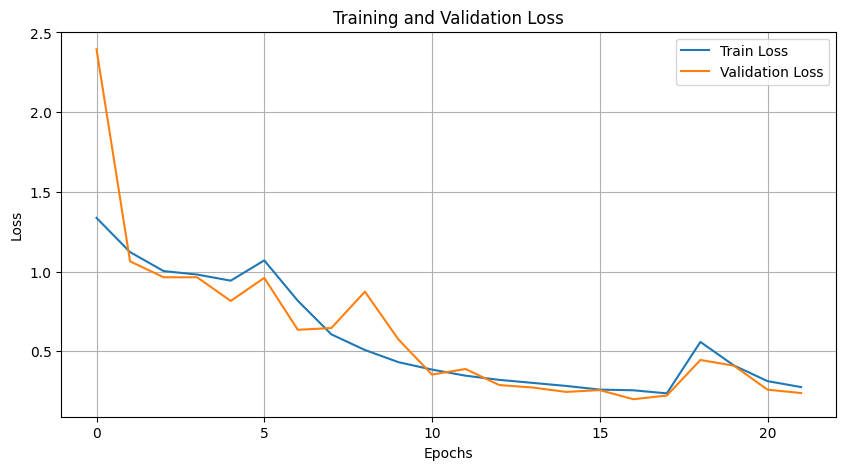

In [ ]:
plot_taining(epoch_train_errors, epoch_val_errors)

In [ ]:
model_classification_report(base_model, test_loader)

Accuracy: 0.9427644801754066
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     18118
           1       0.46      0.65      0.54       556
           2       0.80      0.94      0.86      1448
           3       0.69      0.53      0.60       162
           4       0.93      0.96      0.94      1608

    accuracy                           0.94     21892
   macro avg       0.77      0.81      0.78     21892
weighted avg       0.95      0.94      0.95     21892



# **Resumen final.**

En esta tarea se intetó conseguir que un modelo de RNN pueda captar las principales caracterísitcas del dataset mitbih. El proyecto se dividó en 4 etapas: exploración del dataset, estrategia de balanceo de clases, construcción de modelos de RNN y ejecución de tests en Weights & Bias para descubrir los mejores hiperparámetros.

En la primera etapa es importante destacar que el dataset cuenta con una gran cantidad de datos de pulsiones del corazón y estos dividos en cinco clases. Entre las clases existe un gran desbalance de datos, pues existe una clase con valores por los cientos de miles y el resto con valores entre los miles. Este desbalanceo extremo provoca que tengamos que pensar en estrategias para balancear nuestros datos para que nuestros modelos consiguan comprender y captar las características principales de nuestro problema.

En la segunda etapa, se buscó varias estrategias para balancear datos. La estrategia que más éxito obtuvo fue la de crear un criterio de pérdida llamado ClassBalancedLoss que calcula la frecuencia inversa de cada clase y penaliza con mayor ahinco cuando nuestros modelos se equivocan al predecir la clase de un dato.

La tercera etapa se enfocó en construir los modelos de RNN GRU y LSTM. Ambos cuentan con dropout y batch normalization antes de procesar los layers de Fully Connected. Estas dos estrategias fueron implementadas a fin de regularizar nuestros modelos.

La cuarta etapa fue la ejecución de los modelos y el testing del mejor modelo en Weights & Bias para encontrar los hiperparametros que minimicen la loss en validación. El modelo que presentó un mejor rendimiento fue el RNN-LSTM. Por ello, lo seleccionamos para que sea el modelo donde se encuentren los mejores hiperparámetros. Al realizar los testos en Weights & Bias llegamos un set de hiperparámetros que tuvieron una mejor performance global. Una vez con estos datos, hicimos un último test con nuestro modelo LSTM utilizando los mejores hiperparámetros encontrados. Con el siguiente resultado:


              precision    recall  f1-score   support
           0       0.99      0.98      0.99     14494
           1       0.64      0.85      0.73       445
           2       0.94      0.95      0.94      1158
           3       0.64      0.88      0.74       128
           4       0.98      0.99      0.99      1286

    accuracy                           0.97     17511



---

